In [20]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Dense
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,normalize
from impyute.imputation.cs import fast_knn
from keras import optimizers

In [2]:
df = pd.read_excel(r'D:\Downloads\Train_dataset.xlsx')

In [ ]:
'''cleaning data
drop id,Designation,Region
fill nan of mode_of transport with public(most frequent)
remove "<" from Pulmonary score


In [4]:
df.columns

Index(['people_ID', 'Region', 'Gender', 'Designation', 'Name', 'Married',
       'Children', 'Occupation', 'Mode_transport', 'cases/1M', 'Deaths/1M',
       'comorbidity', 'Age', 'Coma score', 'Pulmonary score',
       'cardiological pressure', 'Diuresis', 'Platelets', 'HBB', 'd-dimer',
       'Heart rate', 'HDL cholesterol', 'Charlson Index', 'Blood Glucose',
       'Insurance', 'salary', 'FT/month', 'Infect_Prob'],
      dtype='object')

In [6]:
df['Region'].unique()

array(['Bhubaneshwar', 'Chandigarh', 'Chennai', 'Delhi', 'Bengaluru'],
      dtype=object)

In [5]:
df.isnull().sum(axis=0)

people_ID                    0
Region                       0
Gender                       0
Designation                  0
Name                        20
Married                      0
Children                   311
Occupation                 747
Mode_transport               3
cases/1M                     0
Deaths/1M                    0
comorbidity                226
Age                          0
Coma score                   0
Pulmonary score              0
cardiological pressure      97
Diuresis                   716
Platelets                  924
HBB                         16
d-dimer                   1114
Heart rate                1114
HDL cholesterol             35
Charlson Index               0
Blood Glucose                0
Insurance                 1090
salary                       0
FT/month                   723
Infect_Prob                  0
dtype: int64

In [42]:
df.drop('Designation',inplace=True,axis=1)

In [172]:
df.head()

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,Bhubaneshwar,0.0,1.0,1.0,Farmer,Public,2,0,Hypertension,68,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,Bhubaneshwar,0.0,1.0,2.0,Farmer,Walk,2,0,Diabetes,64,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,Bhubaneshwar,0.0,0.0,1.0,Cleaner,Public,2,0,None,19,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,Bhubaneshwar,0.0,1.0,1.0,Driver,Car,2,0,Coronary Heart Disease,33,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,Bhubaneshwar,0.0,0.0,2.0,Manufacturing,Car,2,0,Diabetes,23,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


In [46]:
df['Mode_transport'].unique()

array(['Public', 'Walk', 'Car', nan], dtype=object)

In [88]:
level_map = {1:'Farmer',2:'Cleaner',3:'Driver',4:'Manufacturing',5:'Clerk',6:'Sales',7:'Business',8:'Researcher',9:'Legal',10:'nan'}
df['Occupation'] = df['Occupation'].map(level_map)

In [169]:
level_map = {'Female':0.0,'Male':1.0}
df['Gender'] = df['Gender'].map(level_map)

In [171]:
level_map = {'NO':0.0,'YES':1.0}
df['Married'] = df['Married'].map(level_map)

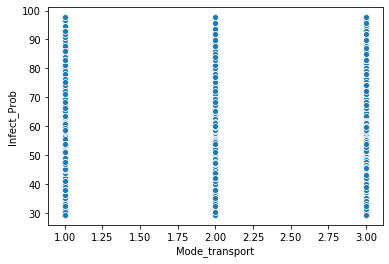

In [78]:
x = df['Mode_transport'].map({'Public':1,'Car':2,'Walk':3,'nan':4})
y = df['Infect_Prob']
sns.scatterplot(x,y)

In [86]:
df['Mode_transport'].fillna('Public',inplace=True)

In [92]:
df['Pulmonary score'].str.replace("<","")

0        400
1        100
2        300
3        200
4        400
        ... 
10709    400
10710    400
10711    100
10712    300
10713    400
Name: Pulmonary score, Length: 10714, dtype: object

In [107]:
df['cardiological pressure'].value_counts()

Normal      2681
Stage-01    2657
Elevated    2641
Stage-02    2638
Name: cardiological pressure, dtype: int64

In [115]:
df['Insurance'].fillna(df['Insurance'].mean().round(),inplace=True)

In [119]:
df['HDL cholesterol'].fillna(df['HDL cholesterol'].mean().round(),inplace=True)

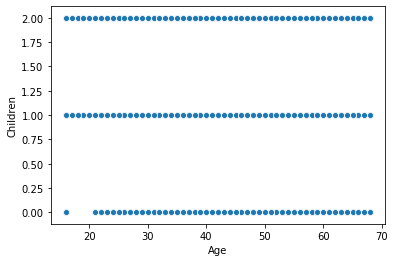

In [124]:
x = df['Age']
y = df['Children']
sns.scatterplot(x,y)

In [148]:
df1 = df.copy()
df1['comorbidity'] = df['comorbidity'].map({'Hypertension':1,'Diabetes':2,'None':3,'Coronary Heart Disease':4,'nan':5})
df['comorbidity'].unique()

array(['Hypertension', 'Diabetes', 'None', 'Coronary Heart Disease', nan],
      dtype=object)

In [153]:
df_corr = df1[['d-dimer','Heart rate']].corr()
print(df_corr)
#sns.heatmap(df_corr, annot=True,)

             d-dimer  Heart rate
d-dimer     1.000000   -0.007661
Heart rate -0.007661    1.000000


In [138]:
df['Children'].fillna(1.0,inplace=True)

In [162]:
df['Heart rate'].fillna(df['Heart rate'].mean().round(),inplace=True)

In [160]:
df.corr()

,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
Children,1.000000,0.010308,0.022132,-0.045764,0.025630,-0.011171,0.022704,0.010029,0.004216,0.004710,-0.005889,-0.019137,0.009774,-0.005512,-0.018515,0.004664,0.208616
cases/1M,0.010308,1.000000,0.987224,0.003632,-0.013573,0.029554,0.007145,0.006044,0.001949,0.014391,0.005111,-0.001050,-0.004485,0.012761,0.008901,0.000730,0.172871
Deaths/1M,0.022132,0.987224,1.000000,0.003991,-0.010302,0.028628,0.009010,0.010402,0.000231,0.011776,0.007679,-0.001806,-0.005483,0.011945,0.008088,0.001679,0.174994
Age,-0.045764,0.003632,0.003991,1.000000,-0.002618,-0.005363,0.011473,0.013863,-0.007124,0.003763,-0.003980,0.002902,0.012601,-0.013099,-0.002901,0.015911,-0.331258
Coma score,0.025630,-0.013573,-0.010302,-0.002618,1.000000,0.002993,-0.013622,0.006823,0.000628,-0.007071,0.007181,-0.005257,0.016351,-0.008772,0.004323,0.001476,0.038400
Diuresis,-0.011171,0.029554,0.028628,-0.005363,0.002993,1.000000,0.008769,0.003815,-0.009163,-0.007016,0.010759,0.013877,-0.010599,0.021475,-0.006715,-0.015995,0.006854
Platelets,0.022704,0.007145,0.009010,0.011473,-0.013622,0.008769,1.000000,-0.007680,0.014225,-0.007276,-0.020019,-0.000349,0.009733,0.001698,-0.010343,0.012937,0.066290
HBB,0.010029,0.006044,0.010402,0.013863,0.006823,0.003815,-0.007680,1.000000,-0.006564,-0.000065,0.004313,0.005606,-0.005473,-0.001429,-0.010863,-0.011885,0.019362
d-dimer,0.004216,0.001949,0.000231,-0.007124,0.000628,-0.009163,0.014225,-0.006564,1.000000,-0.007661,-0.002185,0.001157,-0.002948,0.015962,0.001513,-0.013268,0.021304
Heart rate,0.004710,0.014391,0.011776,0.003763,-0.007071,-0.007016,-0.007276,-0.000065,-0.007661,1.000000,-0.011730,-0.006261,-0.010150,0.008949,-0.000490,0.015347,-0.003647


In [178]:
df1 = df.copy()

In [179]:
df1['comorbidity'].fillna()

0    Hypertension
dtype: object

In [174]:
df1 = df.copy()

# sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# # start the KNN training
# imputed_training=fast_knn(df1.values, k=30)

In [168]:
level_map = {'Farmer':1.0,'Cleaner':2.0,'Driver':3.0,'Manufacturing':4.0,'Clerk':5.0,'Sales':6.0,'Business':7.0,'Researcher':8.0,'Legal':9.0}
df1['Occupation'] = df1['Occupation'].map(level_map)

l_m = {'Hypertension':1.0,'Diabetes':2.0,'None':3.0,'Coronary Heart Disease':4.0}
df1['comorbidity'] = df1['comorbidity'].map(level_map)

In [177]:
df.head()

,Region,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,Bhubaneshwar,0.0,1.0,1.0,Farmer,Public,2,0,Hypertension,68,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,Bhubaneshwar,0.0,1.0,2.0,Farmer,Walk,2,0,Diabetes,64,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,Bhubaneshwar,0.0,0.0,1.0,Cleaner,Public,2,0,None,19,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,Bhubaneshwar,0.0,1.0,1.0,Driver,Car,2,0,Coronary Heart Disease,33,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,Bhubaneshwar,0.0,0.0,2.0,Manufacturing,Car,2,0,Diabetes,23,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


In [180]:
df1 = df.copy()

In [255]:
df1.head()

,Gender,Married,Children,Occupation,Mode_transport,cases/1M,Deaths/1M,comorbidity,Age,Coma score,...,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
0,0.0,1.0,1.0,Farmer,Public,2,0,Hypertension,68,8,...,93.0,233.0,82.0,58.0,27,7,3600000.0,1300000,2.0,49.135010
1,0.0,1.0,2.0,Farmer,Walk,2,0,Diabetes,64,15,...,56.0,328.0,89.0,68.0,5,6,1600000.0,400000,1.0,51.147880
2,0.0,0.0,1.0,Cleaner,Public,2,0,None,19,13,...,137.0,213.0,77.0,43.0,40,6,3400000.0,900000,1.0,73.224000
3,0.0,1.0,1.0,Driver,Car,2,0,Coronary Heart Disease,33,9,...,167.0,275.0,64.0,60.0,27,7,700000.0,2300000,1.0,48.779225
4,0.0,0.0,2.0,Manufacturing,Car,2,0,Diabetes,23,7,...,153.0,331.0,71.0,64.0,32,7,3200000.0,1100000,1.0,87.868800


In [248]:
df1.isnull().sum(axis=0)

Gender                    0
Married                   0
Children                  0
Occupation                0
Mode_transport            0
cases/1M                  0
Deaths/1M                 0
comorbidity               0
Age                       0
Coma score                0
Pulmonary score           0
cardiological pressure    0
Diuresis                  0
Platelets                 0
HBB                       0
d-dimer                   0
Heart rate                0
HDL cholesterol           0
Charlson Index            0
Blood Glucose             0
Insurance                 0
salary                    0
FT/month                  0
Infect_Prob               0
dtype: int64

In [ ]:
'''
 1)first attempt is to filling all the missing values by the most frequent values.
'''

In [192]:
df1['comorbidity'].value_counts()

Hypertension              2642
None                      2637
Diabetes                  2614
Coronary Heart Disease    2595
Name: comorbidity, dtype: int64

In [188]:
df1['Occupation'].mode()

0    Legal
dtype: object

In [189]:
df1['Occupation'].fillna('Legal',inplace=True)

In [194]:
df1.corr()

,Gender,Married,Children,cases/1M,Deaths/1M,Age,Coma score,Diuresis,Platelets,HBB,d-dimer,Heart rate,HDL cholesterol,Charlson Index,Blood Glucose,Insurance,salary,FT/month,Infect_Prob
Gender,1.000000,-0.012987,0.008456,-0.001141,-0.000102,-0.005604,0.010999,0.016595,-0.007681,0.004479,-0.008661,0.007925,0.018223,0.014795,0.009935,0.003668,0.012924,0.001534,-0.000473
Married,-0.012987,1.000000,-0.070652,0.008477,0.009521,0.705147,0.001248,0.007818,-0.000957,0.013613,-0.009335,-0.000822,0.003520,0.003239,0.002554,-0.014727,0.005002,0.005093,-0.465114
Children,0.008456,-0.070652,1.000000,0.010308,0.022132,-0.045764,0.025630,-0.011171,0.022704,0.010029,0.003013,0.005636,-0.005889,-0.019137,0.009774,-0.005512,-0.018515,0.004664,0.208616
cases/1M,-0.001141,0.008477,0.010308,1.000000,0.987224,0.003632,-0.013573,0.029554,0.007145,0.006044,0.001828,0.013684,0.005111,-0.001050,-0.004485,0.012761,0.008901,0.000730,0.172871
Deaths/1M,-0.000102,0.009521,0.022132,0.987224,1.000000,0.003991,-0.010302,0.028628,0.009010,0.010402,0.000184,0.011214,0.007679,-0.001806,-0.005483,0.011945,0.008088,0.001679,0.174994
Age,-0.005604,0.705147,-0.045764,0.003632,0.003991,1.000000,-0.002618,-0.005363,0.011473,0.013863,-0.007045,0.003676,-0.003980,0.002902,0.012601,-0.013099,-0.002901,0.015911,-0.331258
Coma score,0.010999,0.001248,0.025630,-0.013573,-0.010302,-0.002618,1.000000,0.002993,-0.013622,0.006823,0.000598,-0.006705,0.007181,-0.005257,0.016351,-0.008772,0.004323,0.001476,0.038400
Diuresis,0.016595,0.007818,-0.011171,0.029554,0.028628,-0.005363,0.002993,1.000000,0.008769,0.003815,-0.008624,-0.006636,0.010759,0.013877,-0.010599,0.021475,-0.006715,-0.015995,0.006854
Platelets,-0.007681,-0.000957,0.022704,0.007145,0.009010,0.011473,-0.013622,0.008769,1.000000,-0.007680,0.014090,-0.007219,-0.020019,-0.000349,0.009733,0.001698,-0.010343,0.012937,0.066290
HBB,0.004479,0.013613,0.010029,0.006044,0.010402,0.013863,0.006823,0.003815,-0.007680,1.000000,-0.006215,-0.000051,0.004313,0.005606,-0.005473,-0.001429,-0.010863,-0.011885,0.019362


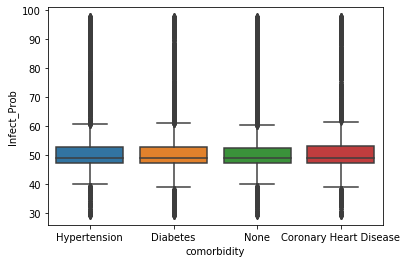

In [197]:
sns.boxplot(x = df1['comorbidity'],y=df1['Infect_Prob'],data=df1)   ''' we can conclude here that there is no depandancy of 
                                                                        comorbodity on Infect_prob so filling with most frequent value will not harm'''

In [208]:
df1 = df.copy()
df1['comorbidity'].mode()

0    Hypertension
dtype: object

In [310]:
df1['Pulmonary score'] = df1['Pulmonary score'].str.replace('<','')

In [311]:
df1['Pulmonary score']

0        400
1        100
2        300
3        200
4        400
        ... 
10709    400
10710    400
10711    100
10712    300
10713    400
Name: Pulmonary score, Length: 10714, dtype: object

In [211]:
df1['comorbidity'].fillna('Hypertension',inplace=True)

In [214]:
df1['cardiological pressure'].mode()

0    Normal
dtype: object

In [218]:
df1['cardiological pressure'].fillna('Normal',inplace=True)

In [221]:
df1['FT/month'].fillna(1.0,inplace=True)

In [3]:
def clean_data(df):
    df1 = df.copy()
    df1.drop(['people_ID', 'Region','Designation','Name'],inplace = True,axis = 1)
    df1['Occupation'].fillna('Legal',inplace=True)
    df1['comorbidity'].fillna('Hypertension',inplace=True)
    df1['Mode_transport'].fillna('Public',inplace=True)
    df1['cardiological pressure'].fillna('Normal',inplace=True)
    df1['Children'].fillna(df1['Children'].mean().round(),inplace=True)
    df1['Diuresis'].fillna(df1['Diuresis'].mean().round(),inplace=True)
    df1['Platelets'].fillna(df1['Platelets'].mean().round(),inplace=True)
    df1['HBB'].fillna(df1['HBB'].mean().round(),inplace=True)
    df1['d-dimer'].fillna(df1['d-dimer'].mean().round(),inplace=True)
    df1['Heart rate'].fillna(df1['Heart rate'].mean().round(),inplace=True)
    df1['Insurance'].fillna(df1['Insurance'].mean().round(),inplace=True)
    df1['FT/month'].fillna('1.0',inplace=True)
    df1['HDL cholesterol'].fillna(df['HDL cholesterol'].mean().round(),inplace=True)
    df1['Pulmonary score'] = df1['Pulmonary score'].str.replace('<','')
    df1['Gender'] = df1['Gender'].map({'Female':0.0,'Male':1.0})
    df1['Married'] = df1['Married'].map({'YES':1.0,'NO':0.0})
    for i in range(10714):
        if df1['Infect_Prob'][i] >= 50.00:
            df1['Infect_Prob'][i] = 1.0
        else:
            df1['Infect_Prob'][i] = 0.0
    return df1

In [4]:
df1 = clean_data(df)

C:\Users\Meet\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Meet\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
df1.isnull().sum(axis=0)

Gender                    0
Married                   0
Children                  0
Occupation                0
Mode_transport            0
cases/1M                  0
Deaths/1M                 0
comorbidity               0
Age                       0
Coma score                0
Pulmonary score           0
cardiological pressure    0
Diuresis                  0
Platelets                 0
HBB                       0
d-dimer                   0
Heart rate                0
HDL cholesterol           0
Charlson Index            0
Blood Glucose             0
Insurance                 0
salary                    0
FT/month                  0
Infect_Prob               0
dtype: int64

In [6]:
LE = LabelEncoder()
le = LE.fit_transform(df1['Occupation'])

In [7]:
ENC = OneHotEncoder(handle_unknown = 'ignore',sparse=False)
#df2 = df1.copy()
ohe = ENC.fit_transform(le.reshape(-1,1))

In [8]:
le1 = LE.fit_transform(df1['Mode_transport'])
ohe_m_t = ENC.fit_transform(le1.reshape(-1,1))

In [9]:
le2 = LE.fit_transform(df1['comorbidity'])
ohe_c = ENC.fit_transform(le2.reshape(-1,1))

In [10]:
le3 = LE.fit_transform(df1['cardiological pressure'])
ohe_c_p = ENC.fit_transform(le3.reshape(-1,1))

In [11]:
X_train = df1[['Gender', 'Married', 'Children','cases/1M', 'Deaths/1M','Age', 'Coma score','Pulmonary score','Diuresis', 'Platelets','HBB', 'd-dimer', 'Heart rate', 'HDL cholesterol', 'Charlson Index',
       'Blood Glucose', 'Insurance', 'salary', 'FT/month']]
Y_train = df1['Infect_Prob']

In [12]:
X_train = X_train.to_numpy()

In [13]:
X_train = np.concatenate([X_train,ohe],axis=1)
X_train = np.concatenate([X_train,ohe_m_t],axis=1)
X_train = np.concatenate([X_train,ohe_c],axis=1)
X_train = np.concatenate([X_train,ohe_c_p],axis=1)

In [14]:
X_train.shape

(10714, 39)

In [15]:
X_train = np.float32(X_train)

In [16]:
X_train

array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 2., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 0., 2., ..., 1., 0., 0.]], dtype=float32)

In [17]:
X_train_normed = (X_train - X_train.mean(axis = 0))/X_train.max(axis=0)

In [18]:
Y_train = df1['Infect_Prob']
Y_train

0        0.0
1        1.0
2        1.0
3        0.0
4        1.0
        ... 
10709    0.0
10710    0.0
10711    0.0
10712    1.0
10713    1.0
Name: Infect_Prob, Length: 10714, dtype: float64

In [19]:
Y_train = Y_train.to_numpy()

In [ ]:
model = keras.models.Sequential()
model.add(Dense(30,input_dim = 39,activation='relu'))
model.add(Dense(units=20,activation='relu'))
model.add(Dense(units=10,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
adam = optimizers.Adam(learning_rate = 0.01,decay = 1e-6)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train,Y_train,epochs=500,batch_size=64)